<a href="https://colab.research.google.com/github/sonia-1234-bot/Netflix_recommendation/blob/main/KaggleNetRecom.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
!pip install surprise

import pandas as pd
import numpy as np
import math
import re
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate
sns.set_style("darkgrid")

In [2]:
df1 = pd.read_csv('/content/combined_data_1.txt', header = None, names = ['Cust_Id', 'Rating'], usecols = [0,1])

df1['Rating'] = df1['Rating'].astype(float)

print('Dataset 1 shape: {}'.format(df1.shape))
print('-Dataset examples-')
print(df1.iloc[::5000000, :])
df2 = pd.read_csv('/content/combined_data_2.txt', header = None, names = ['Cust_Id', 'Rating'], usecols = [0,1])
df3 = pd.read_csv('/content/combined_data_3.txt', header = None, names = ['Cust_Id', 'Rating'], usecols = [0,1])
df4 = pd.read_csv('/content/combined_data_4.txt', header = None, names = ['Cust_Id', 'Rating'], usecols = [0,1])


df2['Rating'] = df2['Rating'].astype(float)
df3['Rating'] = df3['Rating'].astype(float)
df4['Rating'] = df4['Rating'].astype(float)

print('Dataset 2 shape: {}'.format(df2.shape))
print('Dataset 3 shape: {}'.format(df3.shape))
print('Dataset 4 shape: {}'.format(df4.shape))

Dataset 1 shape: (662488, 2)
-Dataset examples-
  Cust_Id  Rating
0      1:     NaN


<ipython-input-2-425067601739>:9: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df3 = pd.read_csv('/content/combined_data_3.txt', header = None, names = ['Cust_Id', 'Rating'], usecols = [0,1])


Dataset 2 shape: (611542, 2)
Dataset 3 shape: (611528, 2)
Dataset 4 shape: (611495, 2)


In [12]:
df = df1
#df = df1.append(df2)
#df = df.append(df3)
#df = df.append(df4)

df.index = np.arange(0,len(df))
print('Full dataset shape: {}'.format(df.shape))
print('-Dataset examples-')
print(df.iloc[::5000000,:])

Full dataset shape: (662488, 2)
-Dataset examples-
  Cust_Id  Rating
0      1:     NaN


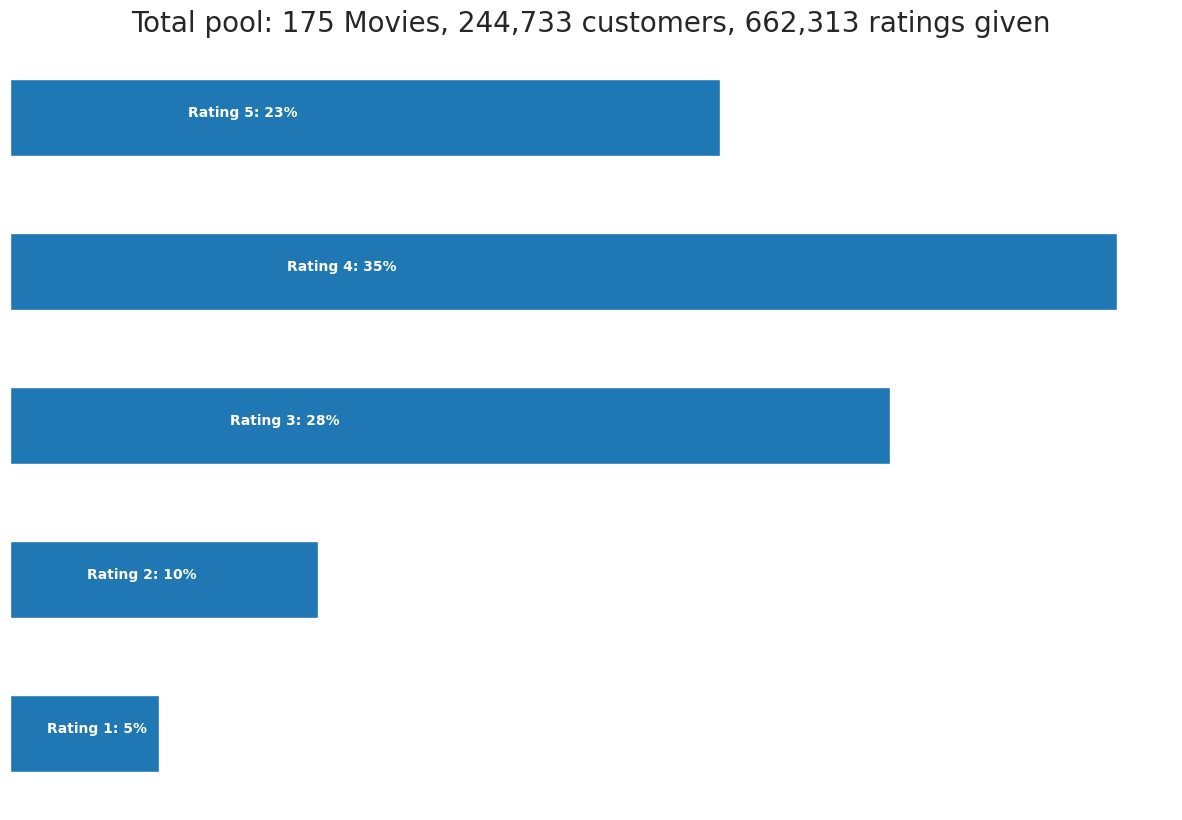

In [13]:
p = df.groupby('Rating')['Rating'].agg(['count'])

# get movie count
movie_count = df.isnull().sum()[1]

# get customer count
cust_count = df['Cust_Id'].nunique() - movie_count

# get rating count
rating_count = df['Cust_Id'].count() - movie_count

ax = p.plot(kind = 'barh', legend = False, figsize = (15,10))
plt.title('Total pool: {:,} Movies, {:,} customers, {:,} ratings given'.format(movie_count, cust_count, rating_count), fontsize=20)
plt.axis('off')
for i in range(1,6):
    ax.text(p.iloc[i-1][0]/4, i-1, 'Rating {}: {:.0f}%'.format(i, p.iloc[i-1][0]*100 / p.sum()[0]), color = 'white', weight='bold')

In [14]:
df_nan = pd.DataFrame(pd.isnull(df.Rating))
df_nan = df_nan[df_nan['Rating'] == True]
df_nan = df_nan.reset_index()

movie_np = []
movie_id = 1

for i,j in zip(df_nan['index'][1:],df_nan['index'][:-1]):
    # numpy approach
    temp = np.full((1,i-j-1), movie_id)
    movie_np = np.append(movie_np, temp)
    movie_id += 1
last_record = np.full((1,len(df) - df_nan.iloc[-1, 0] - 1),movie_id)
movie_np = np.append(movie_np, last_record)

print('Movie numpy: {}'.format(movie_np))
print('Length: {}'.format(len(movie_np)))

Movie numpy: [  1.   1.   1. ... 175. 175. 175.]
Length: 662313


In [15]:
df = df[pd.notnull(df['Rating'])]

df['Movie_Id'] = movie_np.astype(int)
df['Cust_Id'] = df['Cust_Id'].astype(int)
print('-Dataset examples-')
print(df.iloc[::5000000,:])

-Dataset examples-
   Cust_Id  Rating  Movie_Id
1  1488844     3.0         1


<ipython-input-15-fc5c175737c5>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Movie_Id'] = movie_np.astype(int)
<ipython-input-15-fc5c175737c5>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Cust_Id'] = df['Cust_Id'].astype(int)


In [16]:
f = ['count','mean']

df_movie_summary = df.groupby('Movie_Id')['Rating'].agg(f)
df_movie_summary.index = df_movie_summary.index.map(int)
movie_benchmark = round(df_movie_summary['count'].quantile(0.7),0)
drop_movie_list = df_movie_summary[df_movie_summary['count'] < movie_benchmark].index

print('Movie minimum times of review: {}'.format(movie_benchmark))

df_cust_summary = df.groupby('Cust_Id')['Rating'].agg(f)
df_cust_summary.index = df_cust_summary.index.map(int)
cust_benchmark = round(df_cust_summary['count'].quantile(0.7),0)
drop_cust_list = df_cust_summary[df_cust_summary['count'] < cust_benchmark].index

print('Customer minimum times of review: {}'.format(cust_benchmark))

Movie minimum times of review: 1241.0
Customer minimum times of review: 3.0


In [17]:
df_p = pd.pivot_table(df,values='Rating',index='Cust_Id',columns='Movie_Id')
print(df_p.shape)

(244733, 175)


In [18]:
df_title = pd.read_csv('/content/movie_titles.csv', encoding = "ISO-8859-1", header = None, names = ['Movie_Id', 'Year', 'Name'],error_bad_lines=False)
df_title.set_index('Movie_Id', inplace = True)
print (df_title.head(10))

         Year Name
Movie_Id          
NaN       NaN  NaN
NaN       NaN  NaN
NaN       NaN  NaN
NaN       NaN  NaN
NaN       NaN  NaN
NaN       NaN  NaN
NaN       NaN  NaN
NaN       NaN  NaN
NaN       NaN  NaN
NaN       NaN  NaN


<ipython-input-18-d1f084f818ce>:1: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  df_title = pd.read_csv('/content/movie_titles.csv', encoding = "ISO-8859-1", header = None, names = ['Movie_Id', 'Year', 'Name'],error_bad_lines=False)


In [19]:
reader = Reader()

# get just top 100K rows for faster run time
data = Dataset.load_from_df(df[['Cust_Id', 'Movie_Id', 'Rating']][:], reader)
#data.split(n_folds=3)

svd = SVD()
cross_validate(svd, data, measures=['RMSE','MAE'])

{'test_rmse': array([0.99915291, 0.99980597, 0.99853317, 1.00218226, 1.00134096]),
 'test_mae': array([0.77642199, 0.77856275, 0.77730559, 0.78019456, 0.78109739]),
 'fit_time': (10.453188419342041,
  9.949963331222534,
  12.032073259353638,
  10.705793142318726,
  10.718051433563232),
 'test_time': (1.4923217296600342,
  1.115361213684082,
  1.4288253784179688,
  0.8397576808929443,
  1.3388786315917969)}

In [20]:
df_785314 = df[(df['Cust_Id'] == 785314) & (df['Rating'] == 5)]
df_785314 = df_785314.set_index('Movie_Id')
df_785314 = df_785314.join(df_title)['Name']
print(df_785314)

Movie_Id
57     NaN
175    NaN
Name: Name, dtype: object


In [21]:
def recommend(movie_title, min_count):
    print("For movie ({})".format(movie_title))
    print("- Top 10 movies recommended based on Pearsons'R correlation - ")
    i = int(df_title.index[df_title['Name'] == movie_title][0])
    target = df_p[i]
    similar_to_target = df_p.corrwith(target)
    corr_target = pd.DataFrame(similar_to_target, columns = ['PearsonR'])
    corr_target.dropna(inplace = True)
    corr_target = corr_target.sort_values('PearsonR', ascending = False)
    corr_target.index = corr_target.index.map(int)
    corr_target = corr_target.join(df_title).join(df_movie_summary)[['PearsonR', 'Name', 'count', 'mean']]
    print(corr_target[corr_target['count']>min_count][:10].to_string(index=False))

In [ ]:
recommend("What the #$*! Do We Know!?",0)


In [ ]:
recommend("X2: X-Men United", 0)


